# Price Prediction

**The exploratory analysis of the dataset has revealed/uncoverd a lot of interesting trends in the Airbnb listings based on their location,
type of service they offer and has also shown us the Price distribution for the listings over the regions in New York City.**

**The next step is to build Price prediction model.**


**We will use a number of techniques and algorithms to build different regression models for Price prediction and compare the results. The different techniques we would be using are :**

> 1) Random Forest

> 2) Gradient Boosting

> 3) XGBoost

**Finally, we will also build a neural network and compare its performance with these standard machine learning algorithms.**

**We will be using sklearn library to build these models. We will perform k-fold cross validation and calculate the cross validation score for each model. Using this score along with the other metrics such as MAE, RMSE, R2-score we will find out the best model for the price prediction task on this dataset.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**1. Read the dataset into pandas dataframe**

In [3]:
# Read the dataset into a pandas dataframe.

airbnb_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AB_NYC_2019.csv")
airbnb_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


**2. Check the dataset for null values. Null values would affect the predictions and should be handled before we use this data for predictions.**

In [4]:
# Check for null values.
airbnb_data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

**We will drop the columns "id", "name", "host_name", "last_review", "host_id" as these features are not relevant to the analysis of the data as we explained in the data analysis step earlier at the top. Furthermore, "last_review" feature gives the date of the last review which is also not relevant for prediction of price for the listing.**

**3. Drop the unwanted features from the dataset.**

In [5]:
airbnb_data = airbnb_data.drop(["id", "name", "host_id", "host_name", "last_review"], axis = 1)
airbnb_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


**4. The reviews_per_month feature has a lot of null values, which we will replace with 0.**

In [0]:
airbnb_data['reviews_per_month'].fillna(0, inplace = True)

**5. Check the dataset for null values after cleanup.**

In [7]:
# Check for null values again after cleanup.
airbnb_data.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

**6. Check for correlation between the variables using the pearson correlation matrix.**

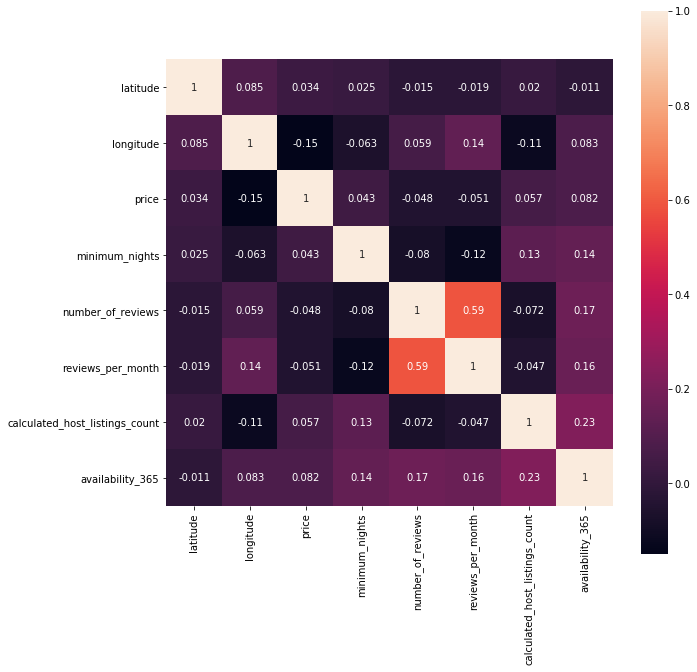

In [8]:
corr_matrix = airbnb_data.corr("pearson")
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, square=True, annot=True)

**From the above, we do not see any strong correlations between variables. So, there is no need to remove any variables because they are strongly correlated and do not add additional information.**

**However, we observe that price and longitude features are inversely related. This makes sense, as based on the exploratory data analysis, listings in Manhattan are expensive than Queens,Bronx.**

**7. Encode the categorical features using One Hot Encoding.**

In [0]:
# The categorical features would be encoded using One Hot Encoding.
# To use the in-built pandas encoding API, we need to convert the categorical columns in our dataset to type categorical.
airbnb_data['neighbourhood_group'] = pd.Categorical(airbnb_data['neighbourhood_group'])
airbnb_data['neighbourhood'] = pd.Categorical(airbnb_data['neighbourhood'])
airbnb_data['room_type'] = pd.Categorical(airbnb_data['room_type'])
one_hot_encode_neighbourhoodgroup = pd.get_dummies(airbnb_data['neighbourhood_group'], prefix = 'category')
one_hot_encode_neighbourhood = pd.get_dummies(airbnb_data['neighbourhood'], prefix = 'category')
one_hot_encode_roomtype = pd.get_dummies(airbnb_data['room_type'], prefix = 'category')
airbnb_data_encoded = pd.concat([airbnb_data, one_hot_encode_neighbourhoodgroup, one_hot_encode_neighbourhood, one_hot_encode_roomtype], axis = 1)

**8. Check the datatypes after encoding. All the categorical features are converted into type 'category' and new features are added as a result of One Hot encoding. So, now we have about 240 features.**

In [10]:
airbnb_data_encoded.dtypes

neighbourhood_group         category
neighbourhood               category
latitude                     float64
longitude                    float64
room_type                   category
                              ...   
category_Woodrow               uint8
category_Woodside              uint8
category_Entire home/apt       uint8
category_Private room          uint8
category_Shared room           uint8
Length: 240, dtype: object

**9. Drop the original categorical features from the dataset as the newly added one hot encoded features would be used for predictions.**

In [0]:
airbnb_data_processed = airbnb_data_encoded.drop(columns=["neighbourhood_group", "neighbourhood", "room_type"], axis=1)

**10. Separate the 'Price' feature from other features as it is the target feature that we are predicting and then drop it from the dataset**

In [12]:
target_y = airbnb_data_processed['price']
airbnb_data_processed_final = airbnb_data_processed.drop(['price'], axis=1)
airbnb_data_processed_final.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,category_Bronx,category_Brooklyn,category_Manhattan,category_Queens,category_Staten Island,category_Allerton,category_Arden Heights,category_Arrochar,category_Arverne,category_Astoria,category_Bath Beach,category_Battery Park City,category_Bay Ridge,category_Bay Terrace,"category_Bay Terrace, Staten Island",category_Baychester,category_Bayside,category_Bayswater,category_Bedford-Stuyvesant,category_Belle Harbor,category_Bellerose,category_Belmont,category_Bensonhurst,category_Bergen Beach,category_Boerum Hill,category_Borough Park,category_Breezy Point,category_Briarwood,category_Brighton Beach,category_Bronxdale,category_Brooklyn Heights,category_Brownsville,category_Bull's Head,...,category_Spuyten Duyvil,category_St. Albans,category_St. George,category_Stapleton,category_Stuyvesant Town,category_Sunnyside,category_Sunset Park,category_Theater District,category_Throgs Neck,category_Todt Hill,category_Tompkinsville,category_Tottenville,category_Tremont,category_Tribeca,category_Two Bridges,category_Unionport,category_University Heights,category_Upper East Side,category_Upper West Side,category_Van Nest,category_Vinegar Hill,category_Wakefield,category_Washington Heights,category_West Brighton,category_West Farms,category_West Village,category_Westchester Square,category_Westerleigh,category_Whitestone,category_Williamsbridge,category_Williamsburg,category_Willowbrook,category_Windsor Terrace,category_Woodhaven,category_Woodlawn,category_Woodrow,category_Woodside,category_Entire home/apt,category_Private room,category_Shared room
0,40.64749,-73.97237,1,9,0.21,6,365,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,1,45,0.38,2,355,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,3,0,0.00,1,365,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,1,270,4.64,1,194,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,10,9,0.10,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [13]:
# Ridge regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso

X_features = airbnb_data_processed_final.columns
scaler = MinMaxScaler()
airbnb_data_processed_final_copy = airbnb_data_processed_final.copy()
X_train, X_test, y_train, y_test = train_test_split(airbnb_data_processed_final_copy[X_features], target_y, test_size=0.2, random_state = 0)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = Ridge(alpha=0.01, fit_intercept=True, random_state=0)
model.fit(X_train, y_train)

Y_pred = model.predict(X_test)

print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, Y_pred))

print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, Y_pred)))
print("R2 score: ", metrics.r2_score(y_test, Y_pred))

# Use 10-fold cross validation and calculate cross-validation score.
airbnb_data_processed_final_copy_1 = airbnb_data_processed_final.copy()
X = airbnb_data_processed_final_copy_1[X_features]
X = scaler.fit_transform(X)
print("Cross validation score: ", -cross_val_score(model, X, target_y, scoring='neg_mean_squared_error', cv=10).mean())

Mean Absolute Error:  70.77230086666896
Root Mean Squared Error:  219.79917926053102
R2 score:  0.12221602936208231
Cross validation score:  51499.26550218204


**Here we observe that the RMSE, MAE is very high.**

**12. Check the distribution of the price feature.**

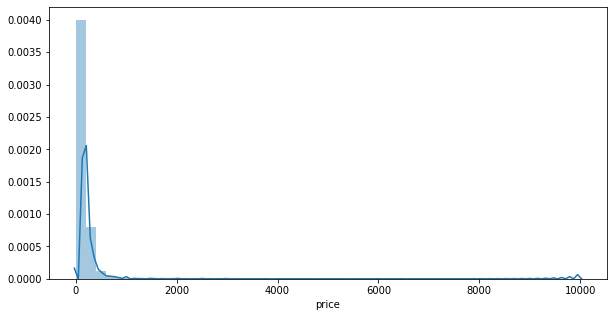

In [14]:
# Price distribution.
plt.figure(figsize=(10,5))
sns.distplot(airbnb_data_processed['price'])

**The above plot shows that the price distribution is highly skewed 
because of which the price prediction was getting highly affected. So, we will normalize it by taking the log of price and update the dataset with that value.**

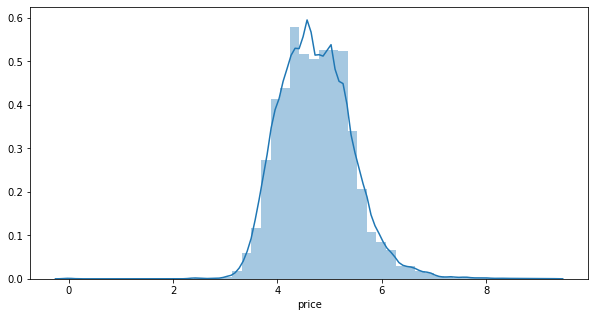

In [15]:
# Add log normalized price to the dataset.
airbnb_data_processed['price'] = np.log1p(airbnb_data_processed['price'])
plt.figure(figsize=(10,5))
# Plot the distribution again. We observe that the distribution is very close to normal 
# distribution and this should improve our prediction model now.
sns.distplot(airbnb_data_processed['price'])

**13. Get the target variable 'price' from the dataset.**

In [16]:
target_y = airbnb_data_processed['price']
airbnb_data_processed_final = airbnb_data_processed.drop(['price'], axis=1)
airbnb_data_processed_final.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,category_Bronx,category_Brooklyn,category_Manhattan,category_Queens,category_Staten Island,category_Allerton,category_Arden Heights,category_Arrochar,category_Arverne,category_Astoria,category_Bath Beach,category_Battery Park City,category_Bay Ridge,category_Bay Terrace,"category_Bay Terrace, Staten Island",category_Baychester,category_Bayside,category_Bayswater,category_Bedford-Stuyvesant,category_Belle Harbor,category_Bellerose,category_Belmont,category_Bensonhurst,category_Bergen Beach,category_Boerum Hill,category_Borough Park,category_Breezy Point,category_Briarwood,category_Brighton Beach,category_Bronxdale,category_Brooklyn Heights,category_Brownsville,category_Bull's Head,...,category_Spuyten Duyvil,category_St. Albans,category_St. George,category_Stapleton,category_Stuyvesant Town,category_Sunnyside,category_Sunset Park,category_Theater District,category_Throgs Neck,category_Todt Hill,category_Tompkinsville,category_Tottenville,category_Tremont,category_Tribeca,category_Two Bridges,category_Unionport,category_University Heights,category_Upper East Side,category_Upper West Side,category_Van Nest,category_Vinegar Hill,category_Wakefield,category_Washington Heights,category_West Brighton,category_West Farms,category_West Village,category_Westchester Square,category_Westerleigh,category_Whitestone,category_Williamsbridge,category_Williamsburg,category_Willowbrook,category_Windsor Terrace,category_Woodhaven,category_Woodlawn,category_Woodrow,category_Woodside,category_Entire home/apt,category_Private room,category_Shared room
0,40.64749,-73.97237,1,9,0.21,6,365,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,1,45,0.38,2,355,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,3,0,0.00,1,365,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,1,270,4.64,1,194,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,10,9,0.10,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


**Now that we have normalized the price feature, we can rerun the algorithms with the normalized dataset and evaluate the performance.**

**Note - Similar log transformation could be applied to any numerical feature. Here we are doing it only for the 'price' feature**

* **A note on splitting the data into training/testing datasets and feature scaling -**

> 1) For every model we built, we randomly split the dataset into training and testing datasets. 80% is used for training and 20% is used for testing.

> 2) After we split the data into we scale the features using sklearn's ***MinMaxScaler*** to get all the features on the same scale.

> 3) Also, for each model we perform 10-fold cross validation (5-fold in case of the neural network model) and calculate the cross validation score. This score will be later used for comparison between the models. The cross validation module uses the ***negative mean squared error*** as the scoring metric.

**14. Ridge Regression**

In [17]:
# Ridge regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso

X_features = airbnb_data_processed_final.columns
scaler = MinMaxScaler()
airbnb_data_processed_final_copy = airbnb_data_processed_final.copy()
X_train, X_test, y_train, y_test = train_test_split(airbnb_data_processed_final_copy[X_features], target_y, test_size=0.2, random_state = 0)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = Ridge(alpha=0.01, fit_intercept=True, random_state=0)
model.fit(X_train, y_train)

Y_pred = model.predict(X_test)

mae_ridge = metrics.mean_absolute_error(y_test, Y_pred)
rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, Y_pred))
r2_ridge = metrics.r2_score(y_test, Y_pred)
print("Mean Absolute Error: ", mae_ridge)

print("Root Mean Squared Error: ", rmse_ridge)
print("R2 score: ", r2_ridge)

# Use 10-fold cross validation and calculate cross-validation score.
airbnb_data_processed_final_copy_1 = airbnb_data_processed_final.copy()
X = airbnb_data_processed_final_copy_1[X_features]
X = scaler.fit_transform(X)
cross_val_score_ridge = -cross_val_score(model, X, target_y, scoring='neg_mean_squared_error', cv=10).mean()
print("Cross validation score: ", cross_val_score_ridge)

Mean Absolute Error:  0.33643267654382425
Root Mean Squared Error:  0.4757807742592879
R2 score:  0.5399202136380918
Cross validation score:  0.22713186119315676


**16. Random Forest**

In [18]:
# Random forest.
from sklearn.ensemble import RandomForestRegressor
X_features = airbnb_data_processed_final.columns
scaler = MinMaxScaler()
airbnb_data_processed_final_copy = airbnb_data_processed_final.copy()
X_train, X_test, y_train, y_test = train_test_split(airbnb_data_processed_final_copy[X_features], target_y, test_size=0.2, random_state = 0)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = RandomForestRegressor(n_estimators= 200, max_depth=30, random_state=0)
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
mae_rf = metrics.mean_absolute_error(y_test, Y_pred)
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, Y_pred))
r2_rf = metrics.r2_score(y_test, Y_pred)
print("Mean Absolute Error: ", mae_rf)

print("Root Mean Squared Error: ", rmse_rf)
print("R2 score: ", r2_rf)

# Use 10-fold cross validation and calculate cross-validation score.
airbnb_data_processed_final_copy_1 = airbnb_data_processed_final.copy()
X = airbnb_data_processed_final_copy_1[X_features]
X = scaler.fit_transform(X)

cross_val_score_rf = -cross_val_score(model, X, target_y, scoring='neg_mean_squared_error', cv=10).mean()
print("Cross validation score: ", cross_val_score_rf)

Mean Absolute Error:  0.3295291608823585
Root Mean Squared Error:  0.46348100580310453
R2 score:  0.5634004769028155
Cross validation score:  0.20931790863517205


**17. Gradient Boosting**

> Default parameters are used.

> Important parameters used:

>> **1) n_estimators=100**

>> **2) learning_rate=0.1**

In [20]:
# Gradient boosting.
from sklearn.ensemble import GradientBoostingRegressor
X_features = airbnb_data_processed_final.columns
scaler = MinMaxScaler()
airbnb_data_processed_final_copy = airbnb_data_processed_final.copy()
X_train, X_test, y_train, y_test = train_test_split(airbnb_data_processed_final_copy[X_features], target_y, test_size=0.2, random_state = 0)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Using default parameters.
model = GradientBoostingRegressor(random_state=0)
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)

mae_gbr = metrics.mean_absolute_error(y_test, Y_pred)
rmse_gbr = np.sqrt(metrics.mean_squared_error(y_test, Y_pred))
r2_gbr = metrics.r2_score(y_test, Y_pred)
print("Mean Absolute Error: ", mae_gbr)

print("Root Mean Squared Error: ", rmse_gbr)
print("R2 score: ", r2_gbr)

# Use 10-fold cross validation and calculate cross-validation score.
airbnb_data_processed_final_copy_1 = airbnb_data_processed_final.copy()
X = airbnb_data_processed_final_copy_1[X_features]
X = scaler.fit_transform(X)
cross_val_score_gbr = -cross_val_score(model, X, target_y, scoring='neg_mean_squared_error', cv=10).mean()
print("Cross validation score: ", cross_val_score_gbr)

Mean Absolute Error:  0.3256081956597234
Root Mean Squared Error:  0.4608113974199261
R2 score:  0.5684155390184313
Cross validation score:  0.2072618951755821


**18. XGBoost**

In [21]:
# XGBoost

from xgboost import XGBRegressor
from xgboost import cv

X_features = airbnb_data_processed_final.columns
scaler = MinMaxScaler()
airbnb_data_processed_final_copy = airbnb_data_processed_final.copy()
X_train, X_test, y_train, y_test = train_test_split(airbnb_data_processed_final_copy[X_features], target_y, test_size=0.2, random_state = 0)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)

mae_xgb = metrics.mean_absolute_error(y_test, Y_pred)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, Y_pred))
r2_xgb = metrics.r2_score(y_test, Y_pred)

print("Mean Absolute Error: ", mae_xgb)

print("Root Mean Squared Error: ", rmse_xgb)
print("R2 score: ", r2_xgb)

# Cross validation
airbnb_data_processed_final_copy_1 = airbnb_data_processed_final.copy()
X = airbnb_data_processed_final_copy_1[X_features]
X = scaler.fit_transform(X)

cross_val_score_xgb = -cross_val_score(model, X, target_y, scoring="neg_mean_squared_error", cv=10).mean()
print("Cross validation score: ", cross_val_score_xgb)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Mean Absolute Error:  0.3246657309631296
Root Mean Squared Error:  0.45996953537275215
R2 score:  0.569991032548598


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/x

Cross validation score:  0.20736010353408982


**19. Neural Network**

> ***3-layer neural network*** using the sklearn's ***MLPRegressor***. 

>So, our model has 1 input layer, 2 hidden layers (Each with 100 neurons) and 1 output layer. The ***'relu'*** activation function is used with ***'adam'*** optimizer to minimize the RMSE objective function.

> We do not have enough data samples to build a deep network. However, we are able to get comparable results with a small 3-layer network.

> We will perform a 5-fold cross validation and calculate the cross validation score.

In [22]:
# Neural Network.
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics

X_features = airbnb_data_processed_final.columns
scaler = MinMaxScaler()
airbnb_data_processed_final_copy = airbnb_data_processed_final.copy()
X_train, X_test, y_train, y_test = train_test_split(airbnb_data_processed_final_copy[X_features], target_y, test_size=0.2, random_state = 0)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# build the neural network.
model = MLPRegressor(hidden_layer_sizes=(100, 100), random_state=0, max_iter=1000)
model.fit(X_train, y_train)

Y_pred_train = model.predict(X_train)
Y_pred = model.predict(X_test)

# Evaluation on training data.
print("Evaluation on training set.")

print("Mean Absolute Error: ", metrics.mean_absolute_error(y_train, Y_pred_train))
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_train, Y_pred_train)))
print("R2 score: ", metrics.r2_score(y_train, Y_pred_train))

mae_nn = metrics.mean_absolute_error(y_test, Y_pred)
rmse_nn = np.sqrt(metrics.mean_squared_error(y_test, Y_pred))
r2_nn = metrics.r2_score(y_test, Y_pred)

# Evaluation on test data.
print("Evaluation on test set.")

print("Mean Absolute Error: ", mae_nn)
print("Root Mean Squared Error: ", rmse_nn)
print("R2 score: ", r2_nn)

# Cross validation
airbnb_data_processed_final_copy_1 = airbnb_data_processed_final.copy()
X = airbnb_data_processed_final_copy_1[X_features]
X = scaler.fit_transform(X)

cross_val_score_nn = -cross_val_score(model, X, target_y, scoring="neg_mean_squared_error", cv=5).mean()
print("Cross validation score: ", cross_val_score_nn)

Evaluation on training set.
Mean Absolute Error:  0.29176320273121126
Root Mean Squared Error:  0.41462994788781143
R2 score:  0.6428510497624398
Evaluation on test set.
Mean Absolute Error:  0.36139889141992093
Root Mean Squared Error:  0.5079278263618822
R2 score:  0.4756474464945478
Cross validation score:  0.23890182469670762


**20. Model comparison**



In [23]:
mae_list = [mae_rf, mae_gbr, mae_xgb, mae_nn]
rmse_list = [rmse_rf, rmse_gbr, rmse_xgb, rmse_nn]
r2_list = [r2_rf, r2_gbr, r2_xgb, r2_nn]

cv_list = [cross_val_score_rf, cross_val_score_gbr, cross_val_score_xgb, cross_val_score_nn]
models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Neural Network']
comparison_df = pd.DataFrame({'Algorithm': models, 'MAE': mae_list, 'RMSE': rmse_list, 'R2-score': r2_list, 'Cross validation score': cv_list})
print(comparison_df)

           Algorithm       MAE      RMSE  R2-score  Cross validation score
0      Random Forest  0.329529  0.463481  0.563400                0.209318
1  Gradient Boosting  0.325608  0.460811  0.568416                0.207262
2            XGBoost  0.324666  0.459970  0.569991                0.207360
3     Neural Network  0.361399  0.507928  0.475647                0.238902


**The above result shows the comparison between the models using the metrics specified above.(MAE, RMSE, R2-score, Cross Validation Score)**


**1) The results indicate that Gradient Boosting and XGBoost perform better than other algorithms based on the Cross Validation Score.** 

**Both the algorithms have a cross validation score ~ 0.207**

**2) The 3-layer Neural Network we implemented has a cross validation score of 0.239.**